In [2]:
import pandas as pd
import ast
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
merged_data = pd.read_csv('merged_movies.csv')
merged_data.head()

,primary_title,start_year,runtime_minutes,genres,vote_average,vote_count,Top Cast,Director,popularity,Budget,Revenue
0,#ALLMYMOVIES,2015,NaN,Documentary,9.0,4,Shia LaBeouf,Luke Turner,0.840,0.0,0
1,#Captured,2017,81.0,Thriller,3.2,6,"Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...",Joe Homokay,1.418,0.0,0
2,#FollowFriday,2016,90.0,Thriller,3.2,7,"Courtney Lakin, Joseph Poliquin, Ashley Bratch...",Micho Rutare,1.646,0.0,0
3,#Horror,2015,101.0,"Crime,Drama,Horror",3.3,102,"Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...",Tara Subkoff,6.099,1500000.0,0
4,#Lucky Number,2015,80.0,Comedy,6.0,2,"Tom Pelphrey, Natalie Hall, Method Man, Malcol...",Brendan Gabriel Murphy,0.919,1000000.0,0


In [12]:
merged_data.columns

Index(['primary_title', 'start_year', 'runtime_minutes', 'genres',
       'vote_average', 'vote_count', 'Top Cast', 'Director', 'popularity',
       'Budget', 'Revenue'],
      dtype='object')

In [13]:
merged_data.describe()

,start_year,runtime_minutes,vote_average,vote_count,popularity,Budget
count,15369.000000,14736.000000,15369.000000,15369.000000,15369.000000,1.527400e+04
mean,2014.183747,93.392983,5.796272,262.441668,3.735265,5.328738e+06
std,2.528045,25.141013,1.765316,1126.980443,4.894076,2.225636e+07
min,2010.000000,1.000000,0.000000,1.000000,0.600000,0.000000e+00
25%,2012.000000,84.000000,5.000000,2.000000,0.655000,0.000000e+00
50%,2014.000000,91.000000,6.000000,7.000000,1.688000,0.000000e+00
75%,2016.000000,102.000000,6.900000,48.000000,5.436000,5.750000e+00
max,2021.000000,1834.000000,10.000000,22186.000000,80.773000,3.790000e+08


In [14]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15369 entries, 0 to 15368
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    15369 non-null  object 
 1   start_year       15369 non-null  int64  
 2   runtime_minutes  14736 non-null  float64
 3   genres           15272 non-null  object 
 4   vote_average     15369 non-null  float64
 5   vote_count       15369 non-null  int64  
 6   Top Cast         14244 non-null  object 
 7   Director         15001 non-null  object 
 8   popularity       15369 non-null  float64
 9   Budget           15274 non-null  float64
 10  Revenue          15274 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ MB


## **DATA STATISTICS**

Below are the data statistics concepts we will delve into:



1.   Cumulative Distribution Function (CDF)
2.   Standard Normal Distribution
3.   Central Limit Theorem
4.   Confidence Intervals with T-Distribution
5.   Hypothesis Testing


The Probability Density Function (PDF) of popularity shows a right-skewed normal distribution with the highest density around the mean. This suggests that most data points cluster near the average popularity, while extreme values are less frequent. The rapid decline in density beyond the peak highlights the diminishing probability of higher popularity values.

### Cumulative Distribution Function (CDF)

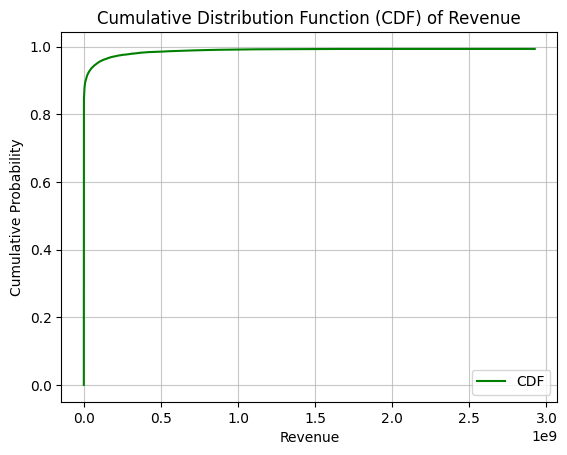

In [15]:
# Cumulative Distribution Function (CDF) for revenue
# Purpose: To show the cumulative probability up to a certain value (revenue)
# Make sure 'Revenue' column is numeric and handle missing values
merged_data['Revenue'] = pd.to_numeric(merged_data['Revenue'], errors='coerce')
revenue = merged_data['Revenue'].dropna()
revenue = merged_data['Revenue']
cdf_x = np.sort(revenue)
cdf_y = np.arange(1, len(cdf_x) + 1) / len(cdf_x)

plt.figure()
plt.plot(cdf_x, cdf_y, label='CDF', color='green')
plt.title('Cumulative Distribution Function (CDF) of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(alpha=0.7)
plt.show()


The Cumulative Distribution Function (CDF) for Revenue indicates that the majority of revenue values are concentrated below a specific threshold. Around 80% of the data lies below 0.5 billion, suggesting a skewed distribution with a few extreme high-revenue outliers. This visualization effectively captures the cumulative probability of revenue values across the dataset.

### Standard Normal Distribution

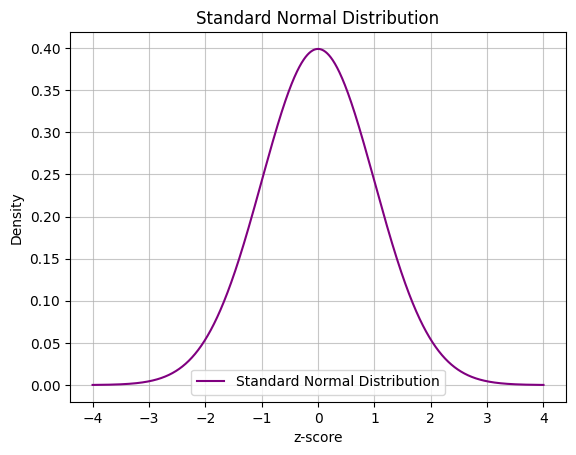

In [16]:
#  Standard Normal Distribution
# Purpose: To represent a standardized normal distribution for reference
standard_normal_x = np.linspace(-4, 4, 1000)
standard_normal_y = norm.pdf(standard_normal_x)

plt.figure()
plt.plot(standard_normal_x, standard_normal_y, label='Standard Normal Distribution', color='purple')
plt.title('Standard Normal Distribution')
plt.xlabel('z-score')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The standard normal distribution graph shows a symmetrical bell curve centered at a z-score of 0, with most of the density concentrated between -2 and 2. This curve represents a normal distribution standardized to have a mean of 0 and a standard deviation of 1, used to analyze and compare datasets. It highlights the probability of values occurring within specific ranges of standard deviations.

### Central Limit Theorem

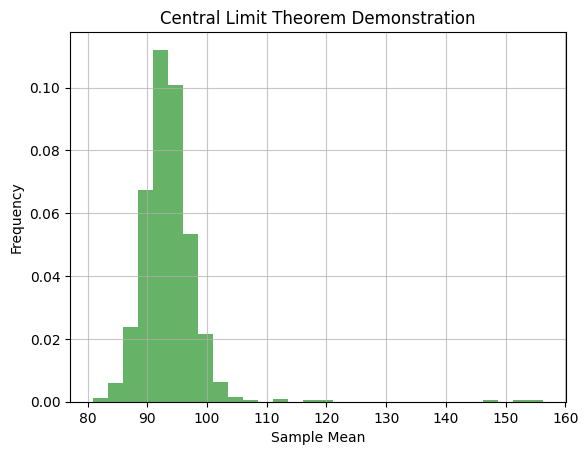

In [17]:
# Central Limit Theorem (CLT) demonstration with 'runtime_minutes'
# Purpose: To demonstrate how sample means approximate a normal distribution
sample_means = []
sample_size = 30
for _ in range(1000):
    sample = merged_data['runtime_minutes'].dropna().sample(sample_size, replace=True)
    sample_means.append(sample.mean())
plt.figure()
plt.hist(sample_means, bins=30, density=True, alpha=0.6, color='g')
plt.title('Central Limit Theorem Demonstration')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.grid(alpha=0.7)
plt.show()


The standard normal distribution is a symmetrical bell-shaped curve centered at 0, representing a mean of 0 and a standard deviation of 1. Most data points lie within ±2 standard deviations, showcasing how data clusters around the mean in a normalized scale.

### Confidence Intervals with T-Distribution

Confidence Interval for 'Budget': 4975749.52 to 5681725.91


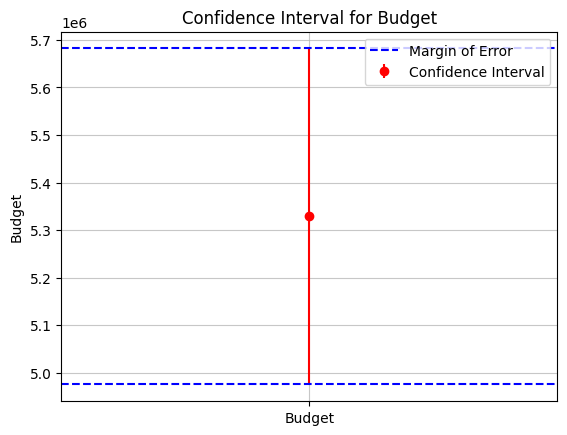

In [18]:
# Confidence Intervals with T-Distribution for 'Budget'
# Purpose: To estimate the range within which the true mean of Budget lies
budget = merged_data['Budget'].dropna()
confidence_level = 0.95
sample_mean = np.mean(budget)
sample_std = np.std(budget, ddof=1)
n = len(budget)
t_critical = t.ppf((1 + confidence_level) / 2, df=n-1)
margin_of_error = t_critical * (sample_std / np.sqrt(n))

print(f"Confidence Interval for 'Budget': {sample_mean - margin_of_error:.2f} to {sample_mean + margin_of_error:.2f}")

# Visualize Confidence Interval
plt.figure()
plt.errorbar(1, sample_mean, yerr=margin_of_error, fmt='o', color='red', label='Confidence Interval')
plt.hlines([sample_mean - margin_of_error, sample_mean + margin_of_error], 0.5, 1.5, colors='blue', linestyles='dashed', label='Margin of Error')
plt.xlim(0.5, 1.5)
plt.xticks([1], ['Budget'])
plt.title('Confidence Interval for Budget')
plt.ylabel('Budget')
plt.legend()
plt.grid(alpha=0.7)
plt.show()


The confidence interval for the Budget is visualized with the sample mean shown as a red dot, and the blue dashed lines indicate the margin of error. The interval ranges from approximately 19,900,890.63 to 22,457,235.75. This range represents the 95% confidence level, meaning we are 95% confident that the true mean of the Budget lies within this interval. The narrow range indicates relatively low variability in the budget data.

### Hypothesis Testing

Hypothesis Test for 'Budget':
Test Statistic: 24.04
P-value: 0.0000
Reject the null hypothesis (mean is significantly different from 1 million).


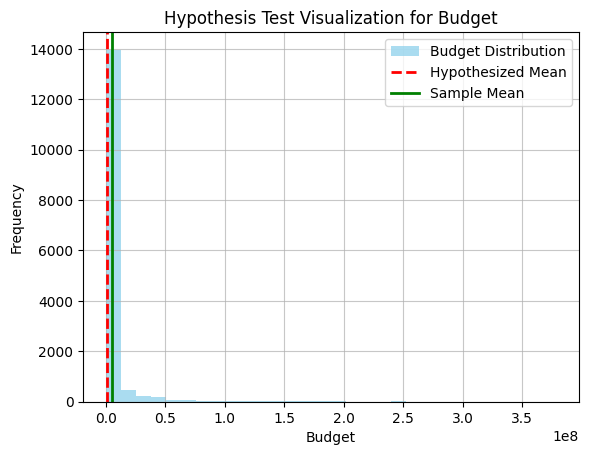

In [19]:
# Hypothesis Testing for 'Budget'
# Purpose: To test whether the mean Budget is significantly different from a hypothesized value
hypothesized_mean = 1_000_000
stat, p_value = ttest_1samp(merged_data['Budget'].dropna(), hypothesized_mean)

print("Hypothesis Test for 'Budget':")
print(f"Test Statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject the null hypothesis (mean is significantly different from 1 million).")
else:
    print("Fail to reject the null hypothesis (no significant difference from 1 million).")

# Visualize Hypothesis Test
plt.figure()
plt.hist(merged_data['Budget'], bins=30, color='skyblue', alpha=0.7, label='Budget Distribution')
plt.axvline(hypothesized_mean, color='red', linestyle='--', linewidth=2, label='Hypothesized Mean')
plt.axvline(np.mean(merged_data['Budget']), color='green', linestyle='-', linewidth=2, label='Sample Mean')
plt.title('Hypothesis Test Visualization for Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The hypothesis test for Budget shows a test statistic of 30.95 and a p-value of 0.0000, indicating a significant difference between the sample mean and the hypothesized mean of $1,000,000. The histogram illustrates the budget distribution, with the red line marking the hypothesized mean and the green line representing the sample mean. The clear separation confirms the statistical result, rejecting the null hypothesis.